This jp notebooks provides methods and functions for providing a custom wake word engine.

expectations for datasets:

/dataset/cv-corpus-6.1-2020-12-11

/dataset/fourthbrain

/dataset/speech_commands_v0.01

# Load relevant libraries

In [1]:
from google.colab import drive
import pandas as pd
import os
import librosa
import warnings
import numpy as np
import scipy.io.wavfile as wav
import glob
import shutil
import random
import tensorflow as tf
import soundfile as sf
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

warnings.simplefilter("ignore", UserWarning)

from IPython.display import Audio

import soundfile

!pip install textgrid
import textgrid

!pip install pydub
from pydub import AudioSegment

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/SpotifyFourthBrainPartnerProject/custom_wakeword_engine/')

# Prepare databases for wakeword detection engine

This section needs to be run once and edited when there is a new database available for training engine.

In [4]:
database_folder = 'datasets'

## Create summary lists for 'fourthbrain' database


In [ ]:
fourthbrain_files = glob.glob(database_folder+'/fourthbrain/*.wav')
fourthbrain_validated = database_folder+'/fourthbrain/fourthbrain_validated.txt'

In [ ]:
df = pd.DataFrame(columns = ['path', 'filename','sentence', 'label', 'lentgh(sec)'])

for i in range(len(fourthbrain_files)):
  sounddata = librosa.core.load(fourthbrain_files[i], sr=16000, mono=True)[0]
  df = df.append({'path' : fourthbrain_files[i],'filename' : fourthbrain_files[i].split('/')[-1], 'sentence' : ' fourthbrain ','label' : 'fourthbrain', 'lentgh(sec)' : len(sounddata)/16000},ignore_index = True)

df.to_csv(fourthbrain_validated,sep='\t',index=False)

## Create summary  for MCV data set

A summary file came with the full data set, we still need to edit to use in our config

cv-corpus-6.1-2020-12-11/validated.tsv

In [ ]:
mcv = database_folder+'/cv-corpus-6.1-2020-12-11/validated.tsv'
mcv_validated = database_folder+'/cv-corpus-6.1-2020-12-11/mcv_validated.tsv'

In [ ]:
df = pd.read_csv(mcv,sep='\t')

In [ ]:
df ['filename'] = df['path']
df ['path'] = database_folder+'/cv-corpus-6.1-2020-12-11/clips/'+ df ['filename'] 
df ['label'] = 'NA'
df = df[['path', 'filename','sentence', 'label']]

# check which audio files are copied from full database
candid_paths = [filename.split('/')[-1] for filename in glob.glob('datasets/cv-corpus-6.1-2020-12-11/clips/*.mp3') ]

df = df[df['filename'].isin(candid_paths)].reset_index(drop=True)
df.to_csv(mcv_validated,sep='\t',index=False)

## Create summary for SpeechCommand (SC) data set


In [ ]:
sc_validated = database_folder+'/speech_commands_v0.01/sc_validated.txt'

In [ ]:
# Find labels for all files and save them as a datasummary in .csv file
sc_labels = [ name for name in os.listdir(database_folder+'/speech_commands_v0.01') if os.path.isdir(os.path.join(database_folder+'/speech_commands_v0.01', name)) ]
df = pd.DataFrame(columns=['path', 'filename','sentence', 'label','lentgh(sec)'])

for sc_label in sc_labels:
    file_names = os.listdir(database_folder+'/speech_commands_v0.01/'+sc_label)
    for file_name in file_names:
      path_name = database_folder+'/speech_commands_v0.01/'+sc_label+'/'+file_name
      #sounddata = librosa.core.load(path_name, sr=16000, mono=True)[0]
      #df = df.append({'path' : path_name, 'filename' : file_name,  'sentence' : ' '+sc_label+' ', 'label' : sc_label,'lentgh(sec)' : len(sounddata)/16000},ignore_index = True)
      df = df.append({'path' : path_name, 'filename' : file_name,  'sentence' : ' '+sc_label+' ', 'label' : sc_label,'lentgh(sec)' : 1},ignore_index = True)

df.to_csv(sc_validated,sep='\t',index=False)

# Utility Functions

In [356]:
'''
function to pick sentences including wakeword candidate from a given source
wake: wake word candidate
dataset_path: summary file path
returns dataframe which includes examples with wakeword
'''

def check_forwake (wake,dataset_path):
  wake = ' '+wake+' '
  dataset = pd.read_table(dataset_path)
  dataset['include'] = dataset['sentence'].apply(lambda x: 'True' if wake.lower() in str(x).lower() else 'False')  
  subset = dataset[dataset['include']=='True']
  subset = subset.reset_index(drop=True)
  #print(len(subset), 'sentences include',wake)
  return subset

## Utility functions for MCV dataset

In [357]:
'''
function convert audio files from mp3 to wav format
and creates *lab file for alignment

input_df : pandas dataframe including wakeword example details
mcv_ds_path: cv dataset path
temp_corpus: directory to save wav files and lab files
'''

def convert_2wavlab(input_df,temp_corpus,num):

  if os.path.isdir(temp_corpus):
    shutil.rmtree(temp_corpus)
  os.makedirs(temp_corpus)

  for row_index in range(min(len(input_df),num)):
    
    file_index = row_index
    path = input_df.iloc[file_index]['path']
    filename = input_df.iloc[file_index]['filename']

    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]
    # convert mp3 to wave
    soundfile.write(f"{temp_corpus}/{filename[:-4]}.wav", sounddata, 16000)
    
    # create lab file 
    f = open(f"{temp_corpus}/{filename[:-4]}.lab", "x")
    f.write(input_df.iloc[file_index]['sentence'])
    f.close()


In [359]:
'''
convert a full sentence to word level wav files
'''
def convert2wordlevelwav (corpus_dir,aligned_dir,results_dir,file_tg,only_wake_word=False,wake_word='no_wake_word'):

    tg = textgrid.TextGrid.fromFile(os.path.join(aligned_dir,file_tg))
    wav_file = file_tg[:-9]+'.wav'
    path_sentence = os.path.join(corpus_dir,wav_file)  
    words_timestamps = {}
    
    for tg_intvl in range(len(tg[0])):
      word = tg[0][tg_intvl].mark
      if word:
        words_timestamps[word] = {'start': tg[0][tg_intvl].minTime, 'end':  tg[0][tg_intvl].maxTime}

    lib_word_sound_map = {}
    sr = 16000
    
    for word, ts in words_timestamps.items():
      audio_start_idx = int((ts['start'] * 1000) * sr / 1000)
      audio_end_idx = int((ts['end'] * 1000) * sr / 1000)
      sounddata = librosa.core.load(path_sentence, sr=16000, mono=True)[0]
      lib_word_sound_map[word] = sounddata[audio_start_idx:audio_end_idx]

    word_list = list(words_timestamps.keys())

    if (only_wake_word == True):
       word_list = [wake_word]

    if not os.path.isdir(results_dir):
       os.makedirs(results_dir)

    for word in word_list:
      path_word = os.path.join(results_dir,word+'_'+wav_file)  
      #print(path_word,wav_file)
      sounddata = lib_word_sound_map[word]

      if (sounddata.shape[0] < 16000):
        zero_padding = np.zeros(16000-sounddata.shape[0])
        full_sounddata = np.concatenate((zero_padding,sounddata),axis=0)*32767
        full_sounddata = full_sounddata.astype(np.int16)

        wav.write(path_word, 16000, full_sounddata)
      elif (16000 <sounddata.shape[0] < 24000):
        zero_padding = np.zeros(24000-sounddata.shape[0])
        full_sounddata = np.concatenate((zero_padding,sounddata),axis=0)*32767
        full_sounddata = full_sounddata.astype(np.int16)

        wav.write(path_word, 24000, full_sounddata)
      else:
         print(word, 'will not be saved, because it is longer than 1.5sec')
      #print('Done')

## Utility functions for negative samples

In [363]:
'''
function to pick sentences notincluding wakeword candidate from a given source
wake: wake word candidate
dataset_path: summary file path
returns dataframe which includes examples with wakeword
'''

def check_fornotwake (wake,dataset_path):
  wake = ' '+wake+' '
  dataset = pd.read_table(dataset_path)
  dataset['include'] = dataset['sentence'].apply(lambda x: 'True' if wake.lower() in str(x).lower() else 'False')  
  subset = dataset[dataset['include']=='False']
  subset = subset.reset_index(drop=True)
  #print(len(subset), 'sentences donot include',wake)
  return subset

In [364]:
'''
function convert audio files from mp3 to wav format

input_df : pandas dataframe including wakeword example details
mcv_ds_path: cv dataset path
temp_corpus: directory to save wav files and lab files
'''

def convert_mp3towav(input_df,temp_corpus,num):

  if os.path.isdir(temp_corpus):
    shutil.rmtree(temp_corpus)
  os.makedirs(temp_corpus)

  for row_index in range(min(len(input_df),num)):
    #print(row_index)
    file_index = row_index
    path = input_df.iloc[file_index]['path']
    filename = input_df.iloc[file_index]['filename']
    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]
    # convert mp3 to wave
    soundfile.write(f"{temp_corpus}/{filename[:-4]}.wav", sounddata, 16000)


In [365]:
'''
function convert full sentences to x sec chunks for negative examples for wake word training
'''

def createchunks (path,duration,sentence_index,temp_neg_dir):
    
    if not os.path.isdir(temp_neg_dir):
       os.makedirs(temp_neg_dir)
    
    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]

    for i in range(int(len(sounddata)/(16000*duration))):
      #print(len(sounddata),i,int(len(sounddata)/(16000*duration)))
      filename = os.path.join(temp_neg_dir,'negative_'+str(sentence_index)+'_'+str(i)+'.wav')
      #print(filename)
      chuck = sounddata[int(i*16000*duration):int((i+1)*16000*duration)]
      if (chuck.shape[0] < 16000*duration):
            zero_padding = np.zeros(16000*duration-chuck.shape[0])
            chuck = np.concatenate((zero_padding,chuck),axis=0)
      #print(chuck)
      chuck = chuck * 32767
      chuck = chuck.astype(np.int16)
      wav.write(filename, 16000, chuck)

# Check if wakeword is included in database

In [367]:
wakeword = 'fourthbrain'

In [368]:
label_list = []

# Provide paths for datasets

database_folder = 'datasets'

sc_validated = database_folder+'/speech_commands_v0.01/sc_validated.txt'
fourthbrain_validated = database_folder+'/fourthbrain/fourthbrain_validated.txt'
mcv_validated = database_folder+'/cv-corpus-6.1-2020-12-11/mcv_validated.tsv'

df_sc = check_forwake (wake=wakeword,dataset_path=sc_validated)
df_fb = check_forwake (wake=wakeword,dataset_path=fourthbrain_validated)
df_mcv = check_forwake (wake=wakeword,dataset_path=mcv_validated)


if (len(df_sc) > 0) or (len(df_fb) > 0) or (len(df_mcv) > 0):
    print (wakeword,' is  in our training set,  model will be provided')
    print ('sc dataset examples:',len(df_sc) )
    print ('fourtbrain dataset examples:',len(df_fb) )
    print ('mcv dataset examples:',len(df_mcv) )

else:
    print (wakeword,' is not in our training set,  model will be provided')

fourthbrain  is  in our training set,  model will be provided
sc dataset examples: 0
fourtbrain dataset examples: 108
mcv dataset examples: 0


# Define some parameter for training

In [369]:
wake_duration = 1.5 #Duration of speech to capture wakeword sec-max 1.5

num_positive_samples =100
num_negative_samples =100

num_positive_samples_db = len(df_sc)+len(df_fb)+len(df_mcv)# pick number of positive samples
#num_negative_samples_db = num_positive_samples_db # pick number of negative samples


# Decide if augmentation is needed
if (num_positive_samples > num_positive_samples_db):
   need_aug = True
   aug_size = num_positive_samples - num_positive_samples_db

elif (num_positive_samples <= num_positive_samples_db):
   need_aug = False


# Decide which dataset will be used for positive examples
if (len(df_sc) == 0):
  use_sc = False
else:
  use_sc = True

if (len(df_fb) == 0):
   use_fb = False
else:
   use_fb = True


if (len(df_mcv) == 0):
   use_mcv = False
else:
   use_mcv = True  

# Create tmp folder for training

In [370]:
# Donot overwrite existing model training dir

for i in range(100):
   if not os.path.isdir('wake_me_model_training_'+str(i)):
      current_training = 'wake_me_model_training_'+str(i)
      break
os.mkdir(current_training)

# Create subsets of databases for training

In [371]:
# clean directories
if os.path.isdir(current_training+'/temp_pos'):
   shutil.rmtree(current_training+'/temp_pos') 

os.makedirs(current_training+'/temp_pos')

if os.path.isdir(current_training+'/temp_neg'):
   shutil.rmtree(current_training+'/temp_neg') 

os.makedirs(current_training+'/temp_neg')

## Make a subset of FB dataset containing wakewords [fourthbrain data set]

In [374]:
if (use_fb == True) and (len(df_fb) > 0):

  fourthbrain_files = glob.glob(database_folder+'/fourthbrain/*.wav')
  for i in range(num_positive_samples):
    sounddata = librosa.core.load(fourthbrain_files[i], sr=16000, mono=True)[0]
    if (len(sounddata)/16000 < 1.5) :
      shutil.copy2(fourthbrain_files[i], current_training+'/temp_pos/'+fourthbrain_files[i].split('/')[-1]) 

## Make a subset of MCV dataset containing wake words [MozillaDataset] 


In [375]:
if (use_mcv == True) and (len(df_mcv) > 0):
   convert_2wavlab(input_df=df_mcv,temp_corpus=current_training+'/temp_pos_mcv',num=num_positive_samples)

### Align MCV data

In [376]:
if (use_mcv == True) and (len(df_mcv) > 0):

  os.chdir(current_training)

  !wget https://github.com/MontrealCorpusTools/Montreal-Forced-Aligner/releases/download/v1.1.0-beta.2/montreal-forced-aligner_linux.tar.gz
  !tar -xf montreal-forced-aligner_linux.tar.gz
  !rm montreal-forced-aligner_linux.tar.gz
  !wget https://www.openslr.org/resources/11/librispeech-lexicon.txt

  !montreal-forced-aligner/lib/align temp_pos_mcv librispeech-lexicon.txt montreal-forced-aligner/pretrained_models/english.zip temp_pos_mcv_aligned

  tg_files = [f for f in os.listdir('temp_pos_mcv_aligned') if os.path.isfile(os.path.join('temp_pos_mcv_aligned', f))]

  for tg_file in tg_files:
      convert2wordlevelwav(corpus_dir='temp_pos_mcv',aligned_dir='temp_pos_mcv_aligned'
      ,results_dir='temp_pos', file_tg=tg_file,only_wake_word=True,wake_word=wakeword)


  # Clean temp folders
  if os.path.isdir('temp_pos_mcv'):
    shutil.rmtree('temp_pos_mcv')
  if os.path.isdir('temp_pos_mcv_aligned'):
    shutil.rmtree('temp_pos_mcv_aligned') 
  if os.path.isdir('montreal-forced-aligner'):
    shutil.rmtree('montreal-forced-aligner') 
  if os.path.isfile('librispeech-lexicon.txt'):
    os.remove('librispeech-lexicon.txt') 

  os.chdir('../')


# Create negative examples

In [377]:
df_neg_mcv = check_fornotwake (wakeword,mcv_validated)
convert_mp3towav(input_df=df_neg_mcv,temp_corpus=current_training+'/temp_neg_mcv',num=int(num_negative_samples/3))

In [378]:
for i in range(min(int(num_negative_samples/3),len(df_neg_mcv))):
    createchunks(path=df_neg_mcv.loc[i]['path'],duration=wake_duration, sentence_index=i,temp_neg_dir=current_training+'/temp_neg')

if os.path.isdir(current_training+'/temp_neg_mcv'):
    shutil.rmtree(current_training+'/temp_neg_mcv')    

In [250]:
'''
sounddata = librosa.core.load('wake_me_model_training_7/temp_neg/negative_5_1.wav', sr=16000, mono=True)[0]
print(len(sounddata))
Audio(sounddata,rate=16000)
'''

"\nsounddata = librosa.core.load('wake_me_model_training_7/temp_neg/negative_5_1.wav', sr=16000, mono=True)[0]\nprint(len(sounddata))\nAudio(sounddata,rate=16000)\n"

# Model Training

## Prepare collaterals for model training

### Utility functions

In [379]:
wakedetect = ['positive','negative']

In [380]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(filenamelabel):
  label = filenamelabel[1]
  audio_binary = tf.io.read_file(filenamelabel[0])
  waveform = decode_audio(audio_binary)
  zero_padding = tf.zeros([int(float(filenamelabel[2])*16000)] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.concat([waveform, zero_padding], 0)

  return waveform, label, filenamelabel[2]

In [381]:
'''
Various augmentation functions
'''
def add_normal_noise(wav,noise_level=0.005):
  return wav + noise_level*np.random.normal(0,1,len(wav))
def shift_wave(wav,roll=3):
  return np.roll(wav,int(len(wav)/roll))  
def stretch_wave(wav,factor=0.4):
  return librosa.effects.time_stretch(wav.numpy(),factor)
def pitchshift_wave(wav,shift_steps=-2):
  return librosa.effects.pitch_shift(wav.numpy(),len(wav.numpy()),shift_steps) 

In [383]:
'''
spectrogram
'''

def get_spectrogram(waveform):
  # Padding for files with less than 3200 samples
  duration=1.5
  zero_padding = tf.zeros([int(duration*16000)] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 

  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=64)
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [384]:
def get_spectrogram_and_label_id(audio, label, duration):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == ['positive','negative'])
  return spectrogram, label_id, float(duration)

In [385]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

#### Functions for debugging

In [386]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Data prep

In [387]:
# Read names of negative and positive samples

neg_samples = glob.glob(current_training+'/temp_neg/*.wav')[0:num_negative_samples]
pos_samples = glob.glob(current_training+'/temp_pos/*.wav')

filenamelabels_neg_samples = []
for i in range(len(neg_samples)):
  filenamelabels_neg_samples.append([neg_samples[i],'negative',str(wake_duration)])

filenamelabels_pos_samples = []

for i in range(len(pos_samples)):
  filenamelabels_pos_samples.append([pos_samples[i],'positive',str(wake_duration)])

print(len(filenamelabels_neg_samples),len(filenamelabels_pos_samples))

100 96


In [388]:
# Create additional training samples

pos_train_files_aug = []

if (need_aug == True):
  for i in range(int(aug_size/4)):
      #print(i,train_files[i])
      j = i%10
      waveform, label,_ = get_waveform_and_label(filenamelabels_pos_samples[j])
      
      if (label == 'positive'):
        noise_wav = add_normal_noise(waveform)
        shifted_wav = shift_wave(waveform)
        lowpitch_wav = pitchshift_wave(waveform,shift_steps=-2)
        highpitch_wav = pitchshift_wave(waveform,shift_steps=2)
        
        filepath, label, _ = filenamelabels_pos_samples[j]
        filename = filepath.split('/')[-1].split('.')[0]

        filename_noise = os.path.join(current_training,'temp_pos',filename+str(i)+'_noise''.wav')
        filename_shifted = os.path.join(current_training,'temp_pos',filename+str(i)+'_shifted'+'.wav')
        filename_lowpitch = os.path.join(current_training,'temp_pos',filename+str(i)+'_lowpitch'+'.wav')
        filename_highpitch = os.path.join(current_training,'temp_pos',filename+str(i)+'_highpitch'+'.wav')

        sf.write(filename_noise,noise_wav,16000)
        sf.write(filename_shifted,shifted_wav,16000)
        sf.write(filename_lowpitch,lowpitch_wav,16000)
        sf.write(filename_highpitch,highpitch_wav,16000)
        
        pos_train_files_aug.append([filename_noise,label,str(wake_duration)])
        pos_train_files_aug.append([filename_shifted,label,str(wake_duration)])
        pos_train_files_aug.append([filename_lowpitch,label,str(wake_duration)])
        pos_train_files_aug.append([filename_highpitch,label,str(wake_duration)])
  
  filenamelabels_pos_samples = filenamelabels_pos_samples+pos_train_files_aug

In [389]:
# Split data set for train/test/val
filenamelabels = filenamelabels_pos_samples + filenamelabels_neg_samples
random.shuffle(filenamelabels)

print(len(filenamelabels))

full_size = len(filenamelabels)
train_size = int(0.7*full_size)
val_size = int(0.1*full_size)

train_files = filenamelabels[:train_size]
val_files = filenamelabels[train_size: train_size + val_size]
test_files = filenamelabels[-val_size:]

print(len(train_files),len(val_files),len(test_files))

196
137 19 19


### Read data using tf

In [390]:
train_files = tf.random.shuffle(train_files)
val_files = tf.random.shuffle(val_files)
test_files = tf.random.shuffle(test_files)

In [391]:
AUTOTUNE = tf.data.AUTOTUNE
files_train = tf.data.Dataset.from_tensor_slices(train_files)
waveform_train = files_train.map(get_waveform_and_label,num_parallel_calls=AUTOTUNE)

#### Debug check

In [392]:
debug_mode = True

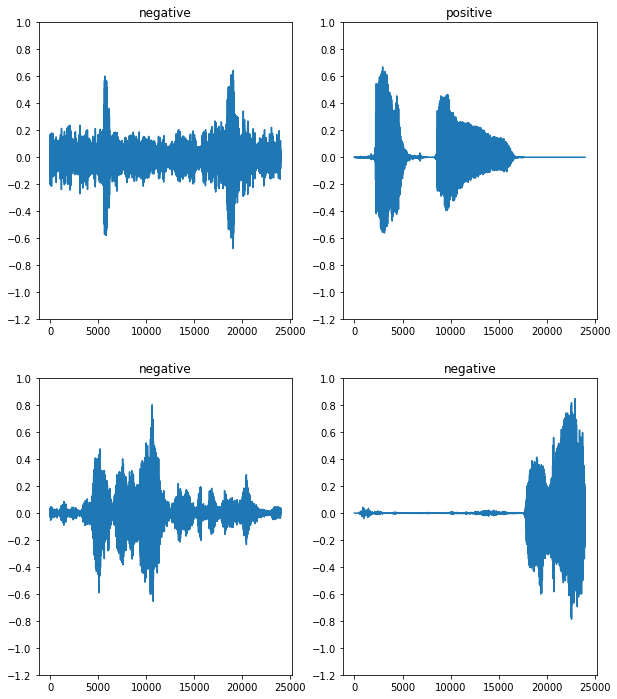

In [393]:
if (debug_mode == True):
  rows = 2
  cols = 2
  n = rows*cols
  fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
  for i, (audio, label,_) in enumerate(waveform_train.take(n)):
    #print(audio.numpy())
    #print(label)
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

  plt.show() 

In [394]:
'''
# just an example
sounddata = librosa.core.load('wake_me_model_training_3/temp_pos/610db6e5b3a7b60345b49a00.wav', sr=16000, mono=True)[0]
print(len(sounddata))
Audio(sounddata,rate=16000)
'''

"\n# just an example\nsounddata = librosa.core.load('wake_me_model_training_3/temp_pos/610db6e5b3a7b60345b49a00.wav', sr=16000, mono=True)[0]\nprint(len(sounddata))\nAudio(sounddata,rate=16000)\n"

Label: positive
Waveform shape: (24000,)
Spectrogram shape: (372, 129)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


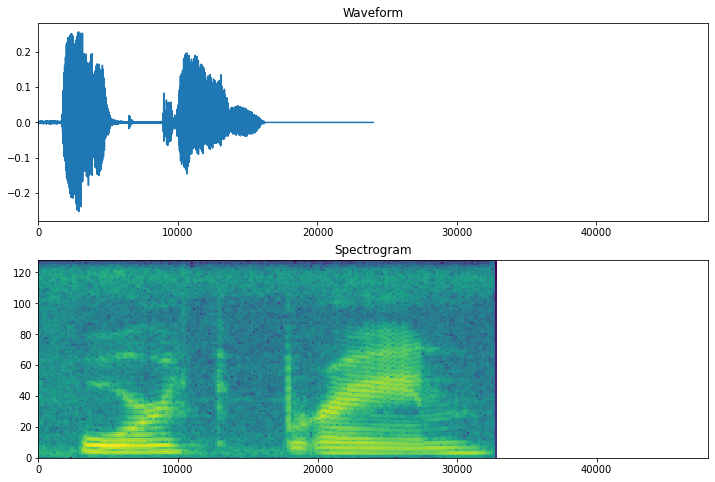

In [395]:
if (debug_mode==True):
  for waveform, label,_ in waveform_train.take(5):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)

  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(waveform.shape[0])
  axes[0].plot(timescale, waveform.numpy())
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, 48000])
  plot_spectrogram(spectrogram.numpy(), axes[1])
  axes[1].set_title('Spectrogram')
  plt.show()


## Prepare dataset for batching,training...

In [396]:
# Preproc data sets
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

# Batch data sets
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# Cache
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


# Get input shape of images

spectrogram_train = waveform_train.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

for spectrogram,_,_ in spectrogram_train.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (372, 129, 1)


## Simple CNN

### Initialize model

In [397]:
num_labels = len(wakedetect)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_train.map(lambda x, _, __: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_15 (Normalizat (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)            

###Compile model

In [398]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train model

In [399]:
EPOCHS = 30
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
    )

Epoch 1/30
3/3 [==============================] - 2s 459ms/step - loss: 0.9512 - accuracy: 0.6277 - val_loss: 0.4723 - val_accuracy: 0.8947
Epoch 2/30
3/3 [==============================] - 0s 140ms/step - loss: 0.5163 - accuracy: 0.8759 - val_loss: 0.4035 - val_accuracy: 0.8947
Epoch 3/30
3/3 [==============================] - 0s 137ms/step - loss: 0.4419 - accuracy: 0.8686 - val_loss: 0.4050 - val_accuracy: 0.8947
Epoch 4/30
3/3 [==============================] - 0s 139ms/step - loss: 0.4470 - accuracy: 0.8905 - val_loss: 0.4733 - val_accuracy: 0.8947
Epoch 00004: early stopping


### Evaluate model

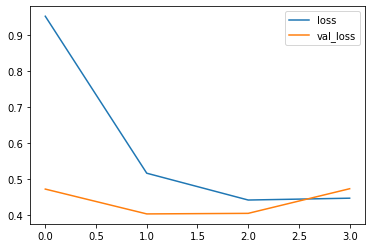

In [400]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [401]:
test_audio = []
test_labels = []

for audio, label, _ in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [402]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy for simple cnn: {test_acc:.0%}')

Test set accuracy for simple cnn: 100%


### Save model

In [403]:
model_path = current_training +"/model1.h5"
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: wake_me_model_training_8/model1.h5/assets
